# imports

In [278]:
#manipulação de dados
import pandas as pd
import numpy  as np

#visualização
import matplotlib.pyplot as plt
import seaborn           as sns
from IPython.core.display import HTML
from IPython.display      import Image

# processamento de dados
from sklearn.model_selection import train_test_split
import pickle

#machine learning models
from lazypredict.Supervised import LazyClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model as lm

#metricas
from sklearn.metrics import accuracy_score, balanced_accuracy_score,precision_score,recall_score,roc_auc_score, confusion_matrix,f1_score

## Helper functions 

In [279]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [280]:
def mult_metrics(model_name,y,yhat):
    return pd.DataFrame({'mode_name':model_name,
             'precison_multclass':precision_score(y,yhat,average='macro'),
             'recall_multclass':recall_score(y,yhat,average='macro'),
              'f1-score_multclass':f1_score(y,yhat,average='macro'),
             'balanced_score':balanced_accuracy_score(y,yhat)},index=[0])
    

In [281]:
def confusion_m(y,yhat):
    from sklearn.metrics import confusion_matrix
    ax= plt.subplot()
    cm = confusion_matrix(y,yhat)
    sns.heatmap(cm,annot=True,ax=ax,annot_kws={'size': 20})
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Heat Dissipation Failure', 'No Failure','Overstrain Failure','Power Failure','Random Failures','Tool Wear Failure']); ax.yaxis.set_ticklabels(['Heat Dissipation Failure', 'No Failure','Overstrain Failure','Power Failure','Random Failures','Tool Wear Failure']);
    plt.yticks(rotation=0) ;

In [303]:
def performace_cross_val(data, target, model, model_name, round_n=3, splits=3, shuffle_n=True, random=42):
    import sklearn.model_selection as ms
    import sklearn.metrics
    import numpy as np
    skf = ms.StratifiedKFold(n_splits=splits, shuffle=shuffle_n, random_state=random)
    X = data
    y = X[target]
    X = X.drop(columns=[target, 'product_id'])
    precision = []
    recall = []
    balan_acc = []
    f1 = []
    for train_index, test_index in skf.split(X, y):
        # train the model
        model.fit(X.iloc[train_index], y.iloc[train_index])

        # predict the classification
        yhat_class = model.predict(X.iloc[test_index])

        # precision and recall
        prec = sklearn.metrics.precision_score(y.iloc[test_index], yhat_class,average='macro')
        rec = sklearn.metrics.recall_score(y.iloc[test_index], yhat_class,average='macro')
        balan_acc_score = sklearn.metrics.balanced_accuracy_score(y.iloc[test_index], yhat_class)
        f1_score = sklearn.metrics.f1_score(y.iloc[test_index], yhat_class,average='macro')
        precision.append(prec)
        recall.append(rec)
        balan_acc.append(balan_acc_score)
        f1.append(f1_score)

    # return a dataset with the metrics
    return pd.DataFrame({'Model name': model_name + " Cross_Val",
                         'precison_multclass_cv': np.round(np.mean(precision), round_n),
                         'precison_std': np.round(np.std(precision), round_n),
                         'recall_multclass_cv': np.round(np.mean(recall), round_n),
                         'recall_cv': np.round(np.std(recall), round_n),
                         'balanced_score_cv': np.round(np.mean(balan_acc), round_n),
                         'balanced_std': np.round(np.std(balan_acc), round_n),
                         'f1_score_cv': np.round(np.mean(f1), round_n),
                         'f1_std': np.round(np.std(f1), round_n)},index=[0])


# Load data

In [282]:
path_local = 'C:/Users/Lavin/Documents/desafios/desafio_indicium/'
df4 = pd.read_csv(path_local + 'data/processed/df_train_processed.csv')

In [283]:
df4.head()

,product_id,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,M14860,0.30,0.36,0.25,0.19,-1.00,1
1,L47181,0.32,0.37,-0.50,0.45,-0.97,1
2,L47184,0.32,0.37,-0.50,-0.01,-0.92,1
3,M14865,0.30,0.36,-0.41,0.12,-0.90,1
4,L47186,0.30,0.36,0.29,0.16,-0.87,1


## Split dataframe

In [284]:
X = df4.copy()
y = X['failure_type']
X = X.drop(columns=['failure_type','product_id'])

In [285]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [286]:
X_train.shape

(4666, 5)

In [287]:
X_val.shape

(2001, 5)

#  Machine learning model

**Nesse momento iremos testar alguns algoritmos de machine learning para ver qual apresenta os melhores resultados, entretanto dois pontos tem de ser destacados:**

    - Não será considerado o fato do desbalancemento das classes nesse ciclo, no proximo cicloi os pesos das classes serão ajustados, assim esse primeiro teste servera como uma baseline para observarmos o quanto foi melhorado.
    
    - As métricas utilizadas seão precison, recall e f1 score. todas utilizando o parametro 'macro' que calcula média  das métricas entre as classes preditas.
    
    - Também será utilizado a matrix de confusão para melhor visualizar os resultados verdadeiros vs o predito


##  Linear regression

In [288]:
lr_model = lm.LogisticRegression().fit(X_train,y_train)

yhat_lr = lr_model.predict(X_val)

lr_metrics = mult_metrics('logistc_regression',y_val,yhat_lr)
lr_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,logistc_regression,0.43,0.31,0.35,0.31


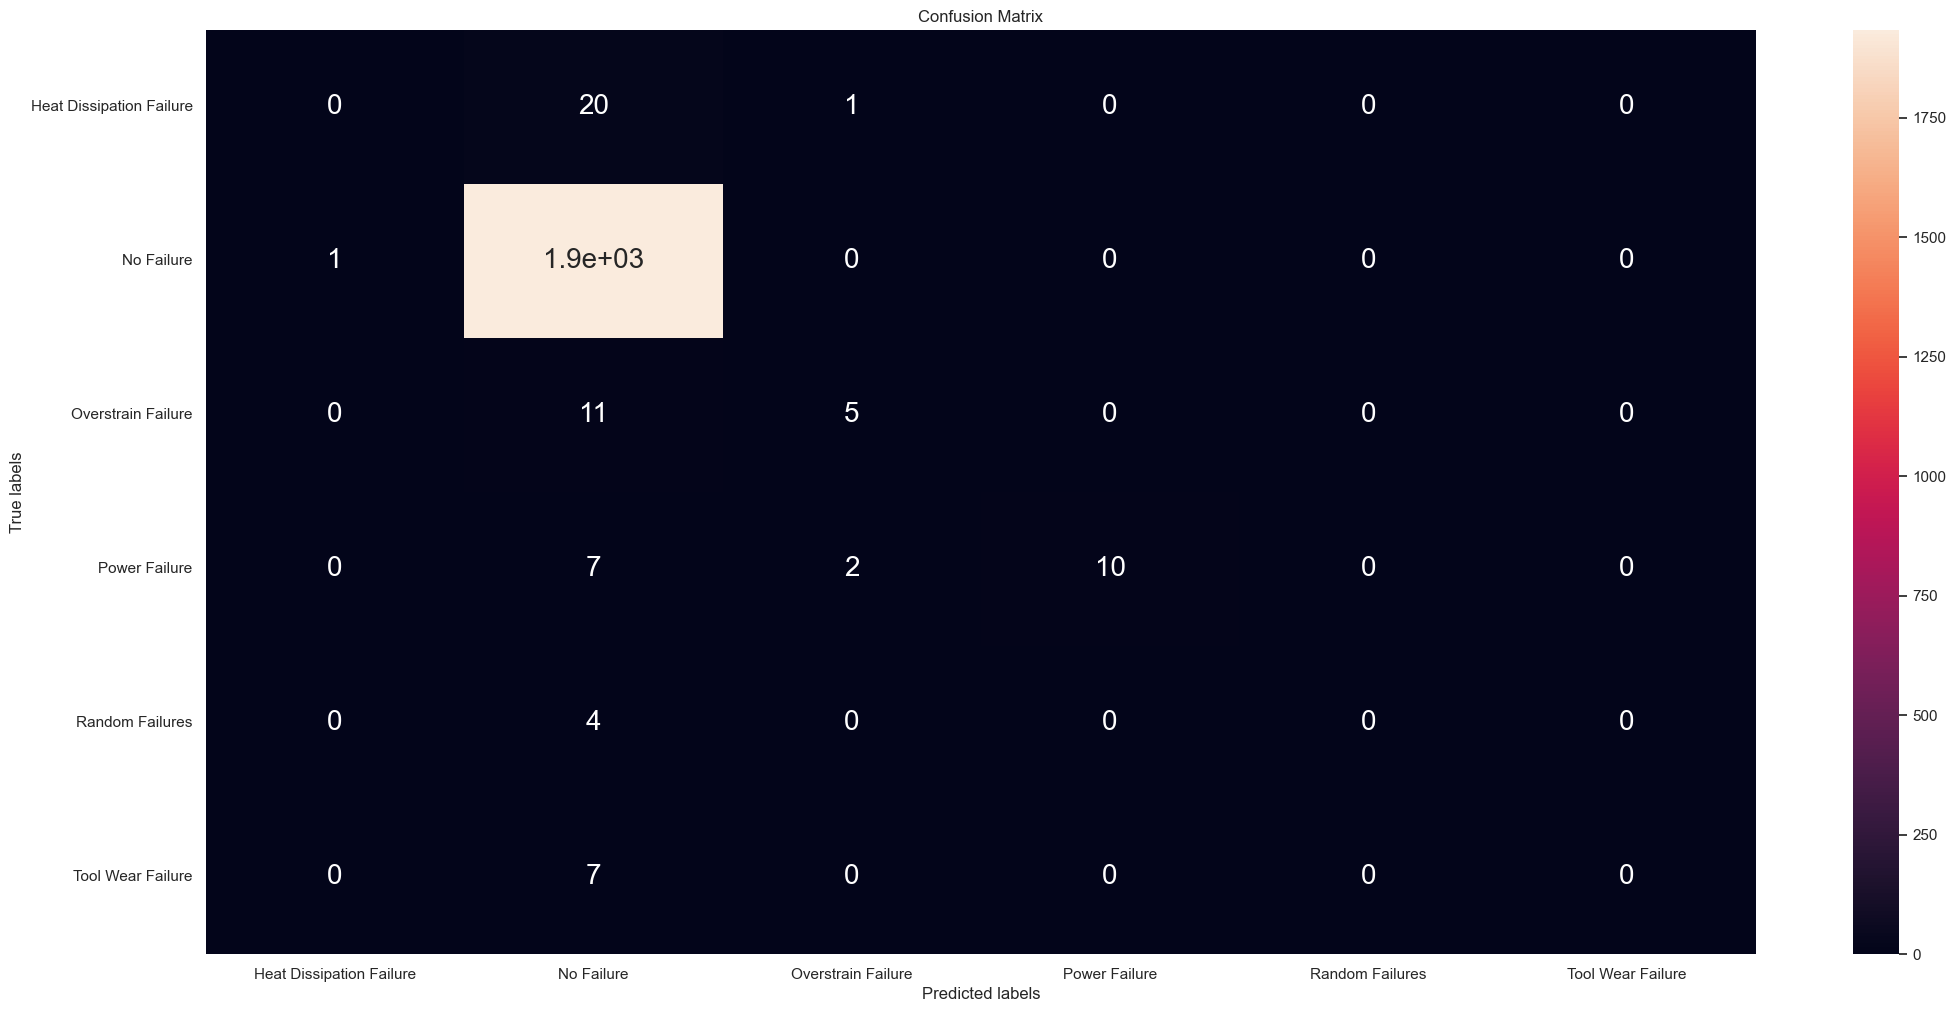

In [289]:
confusion_m(y_val,yhat_lr)

## KNN

In [290]:
#model
knn_model = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)

# model training
yhat_knn = knn_model.predict(X_val)

#metrics
knn_metrics = mult_metrics('knn',y_val,yhat_knn)
knn_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,knn,0.44,0.36,0.39,0.36


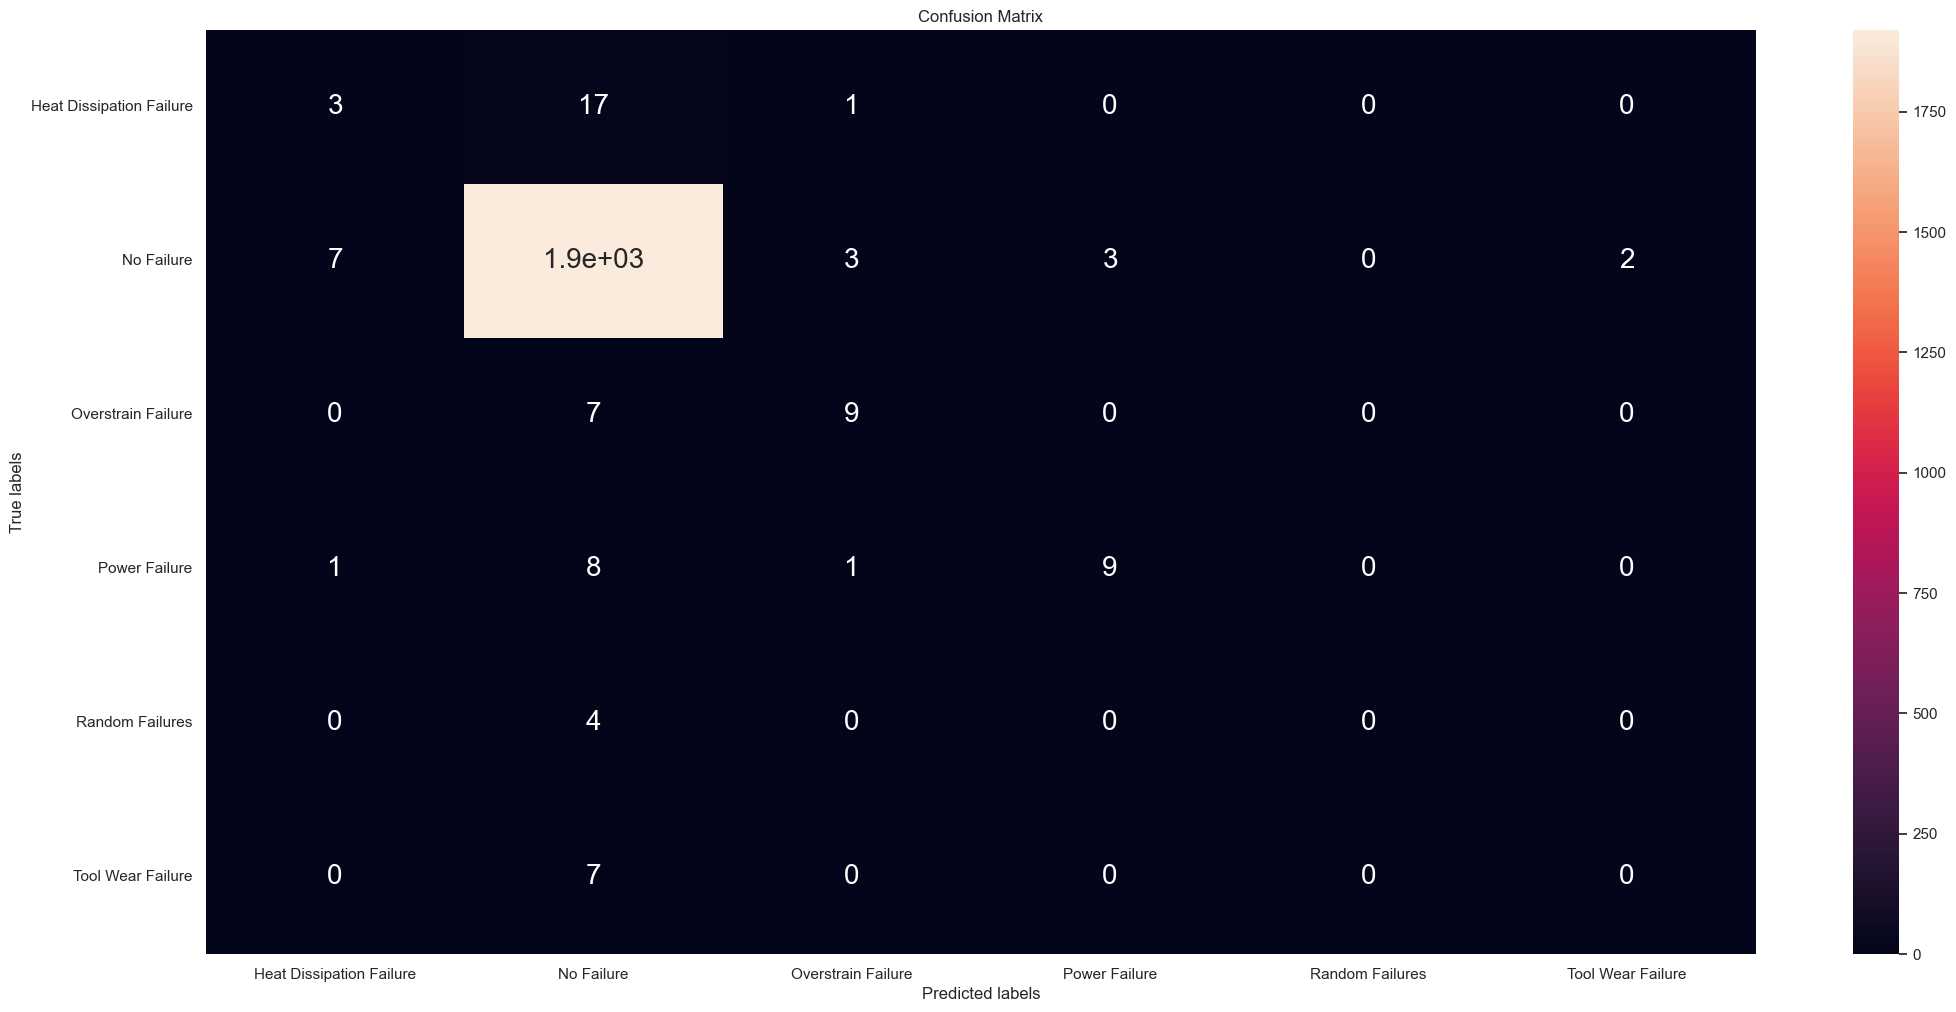

In [291]:
confusion_m(y_val,yhat_knn)

## Random forrest 

In [292]:
#model training
rf_model = RandomForestClassifier(n_estimators=300,random_state=42,n_jobs=-1,class_weight='balanced').fit(X_train,y_train)

#model_predict
yhat_rf = rf_model.predict(X_val)

#metrics
rf_metrics= mult_metrics('random_forrest',y_val,yhat_rf)
rf_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,random_forrest,0.58,0.45,0.50,0.45


## Extratree classifier

In [293]:
#model training
et_model = ExtraTreesClassifier(n_estimators=300,random_state=42,n_jobs=-1).fit(X_train,y_train)

#model predict
yhat_et = et_model.predict(X_val)

#metrics
et_metrics  = mult_metrics('extra_tree',y_val,yhat_et)
et_metrics 

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,extra_tree,0.60,0.35,0.42,0.35


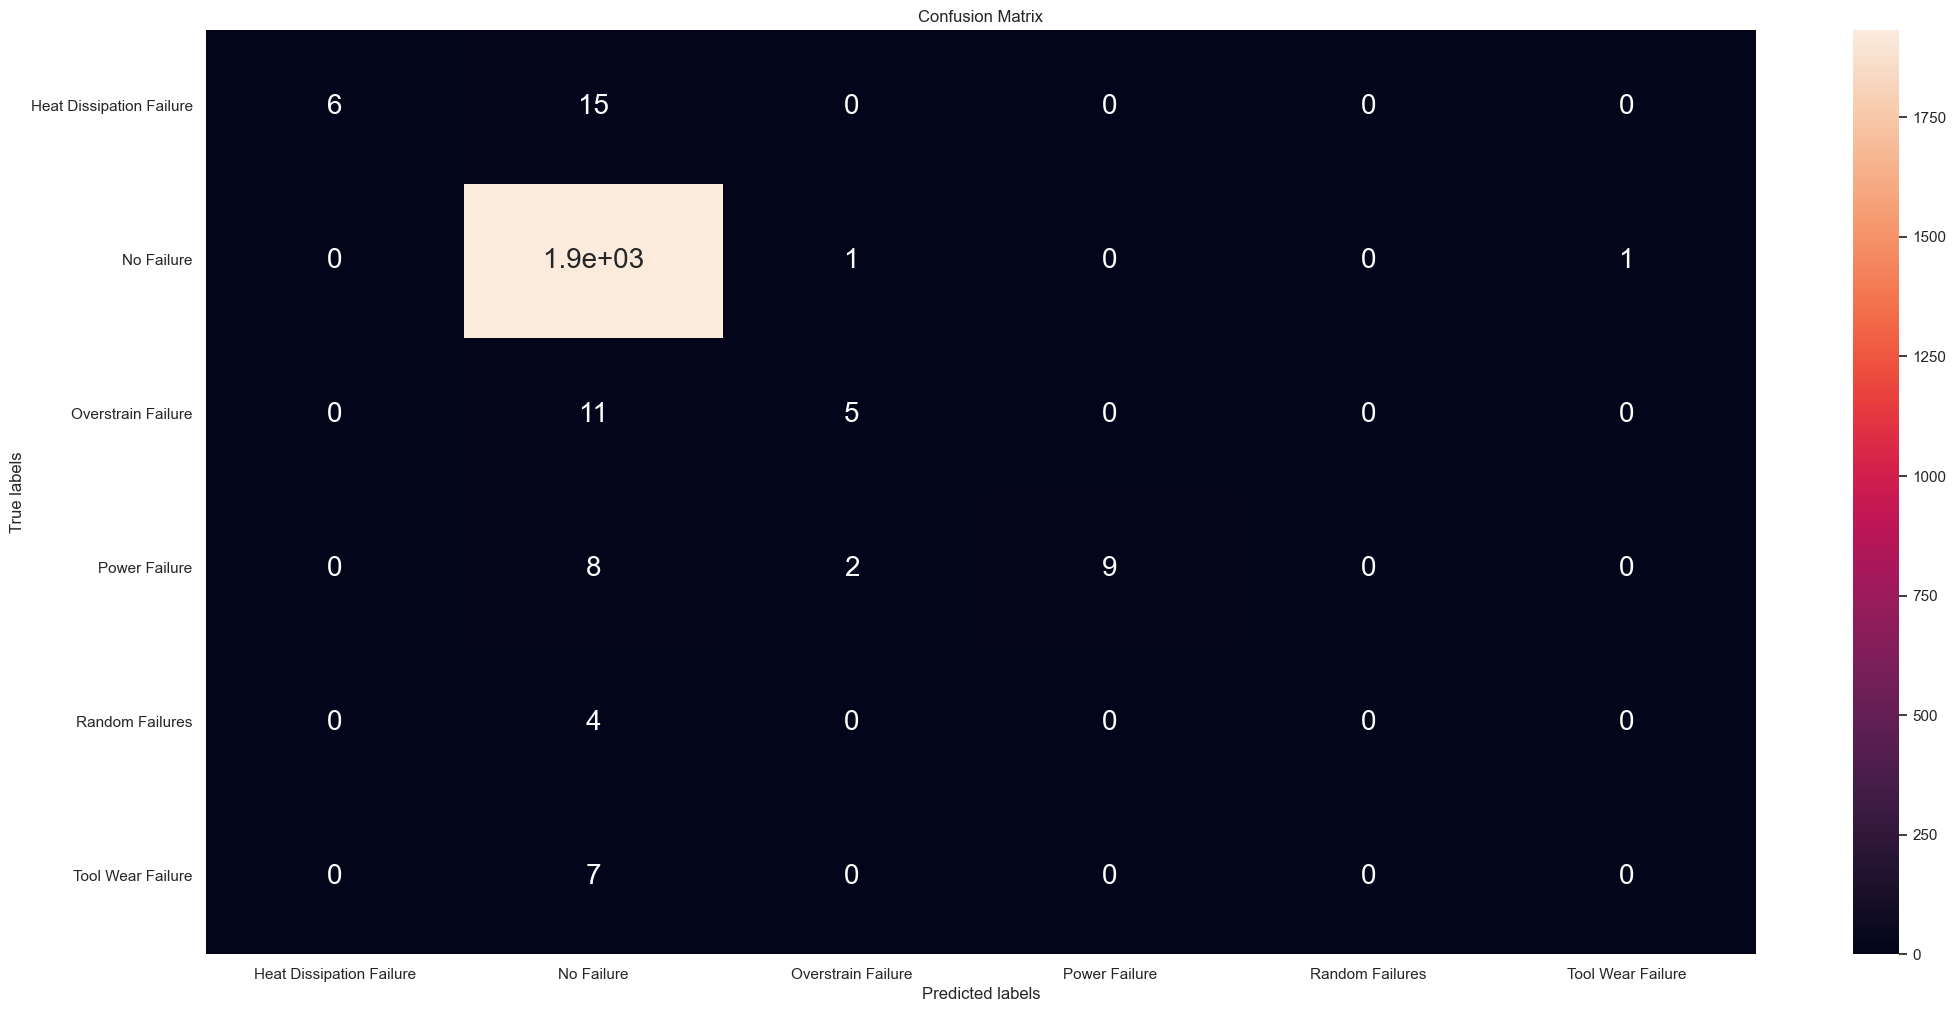

In [294]:
#confusion matrix
confusion_m(y_val,yhat_et)

## Xgboost

In [295]:
#model
xgb_model = xgb.XGBClassifier(n_estimators=300,seed=42).fit(X_train,y_train)

#predict
yhat_xgb = xgb_model.predict(X_val)

#metrics
xgb_metrics = mult_metrics('xgboost',y_val,yhat_xgb)
xgb_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,xgboost,0.56,0.52,0.54,0.52


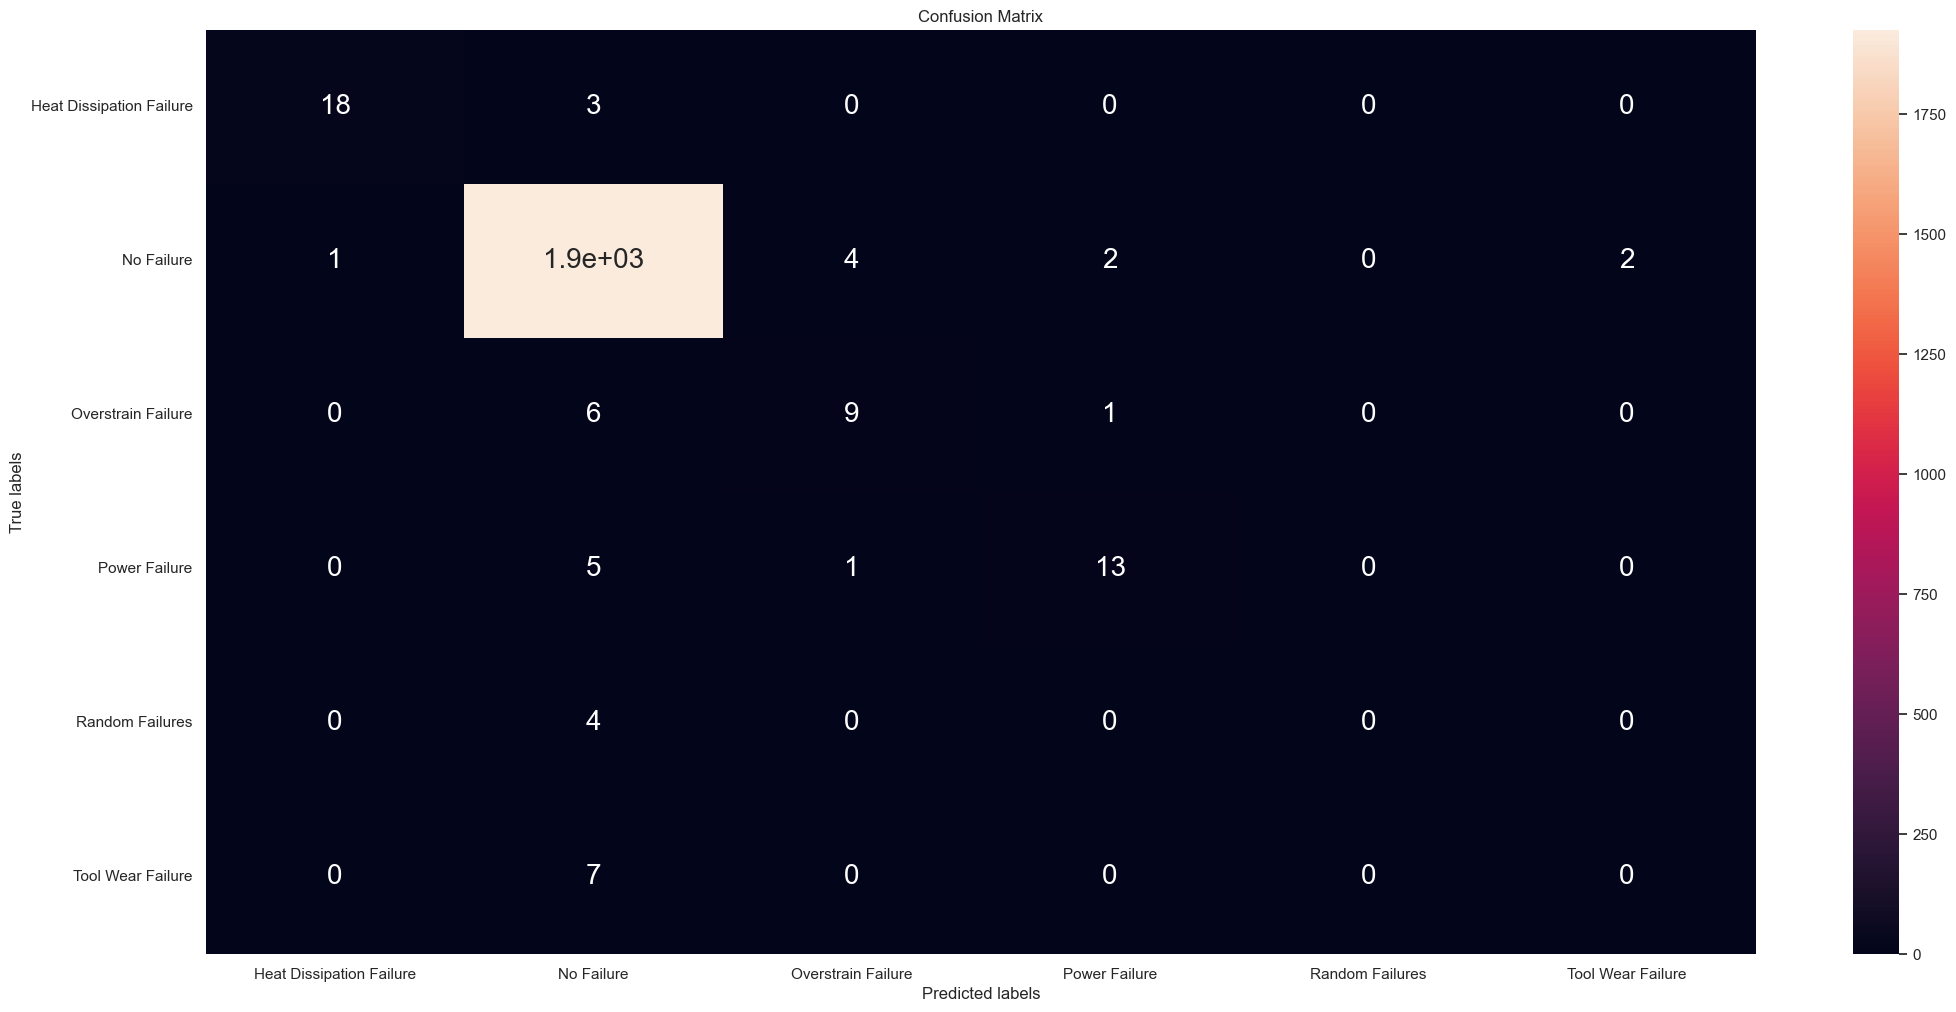

In [296]:
#confusion matrix
confusion_m(y_val,yhat_xgb)

## lightgbm

In [297]:
#model
lgb_model = lgb.LGBMClassifier(n_estimators=300,seed=42).fit(X_train,y_train)

#predict
yhat_lgb = lgb_model.predict(X_val)

#metrics
lgb_metrics = mult_metrics('light',y_val,yhat_lgb)
lgb_metrics

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,light,0.55,0.50,0.52,0.50


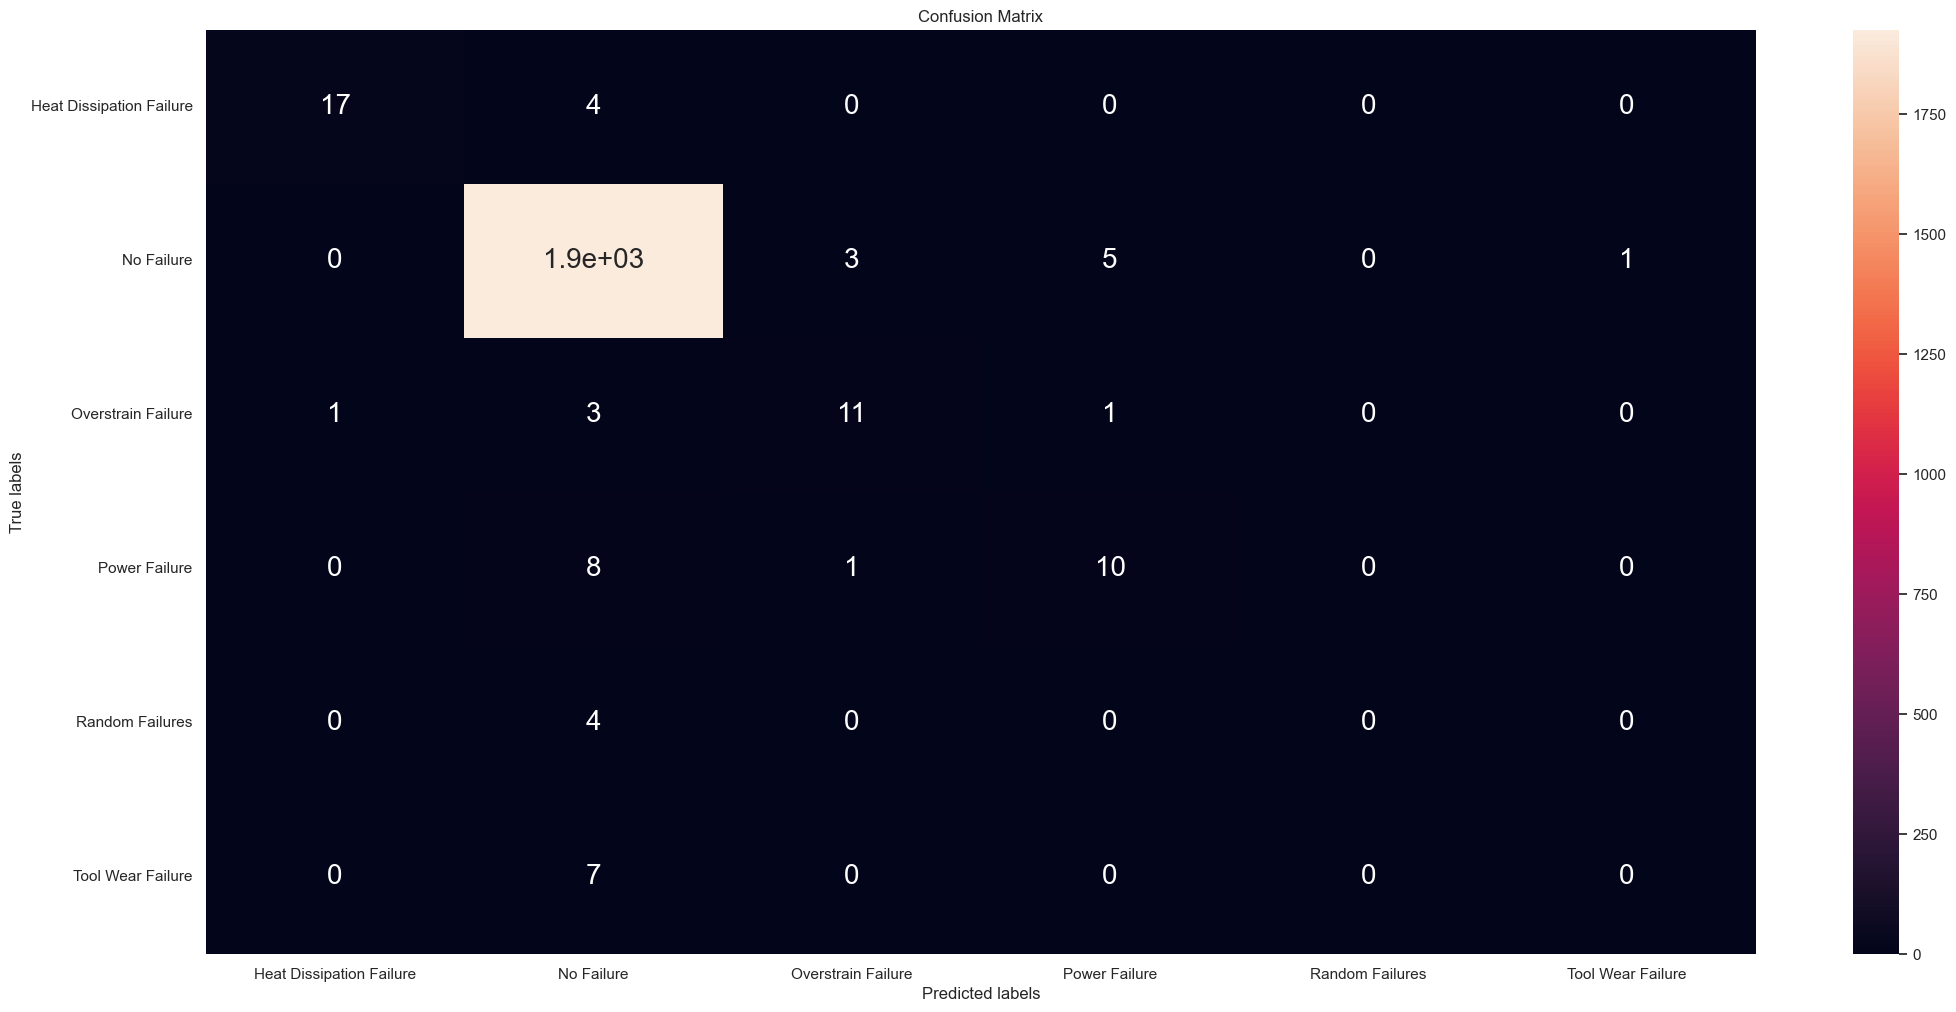

In [298]:
#confusion matrix
confusion_m(y_val,yhat_lgb)

# Model comparison 

In [299]:
model_comp = pd.concat([knn_metrics,lr_metrics,rf_metrics,et_metrics,xgb_metrics,lgb_metrics])

In [301]:
model_comp.sort_values(by='recall_multclass',ascending=False)

,mode_name,precison_multclass,recall_multclass,f1-score_multclass,balanced_score
0,xgboost,0.56,0.52,0.54,0.52
0,light,0.55,0.50,0.52,0.50
0,random_forrest,0.58,0.45,0.50,0.45
0,knn,0.44,0.36,0.39,0.36
0,extra_tree,0.60,0.35,0.42,0.35
0,logistc_regression,0.43,0.31,0.35,0.31


## Cross validation

In [304]:
models = {
    'KNN': knn_model,
    'Linear model': lr_model,
    'Random forrest': rf_model,
    'Extra trees': et_model,
    'XGBoost':xgb_model,
    'Lightgbm':lgb_model
}
models_comparison = pd.DataFrame()

In [305]:
for c, v in models.items():
    aux = performace_cross_val(df4,'failure_type',v,c)
    models_comparison = pd.concat([models_comparison,aux])

In [308]:
models_comparison.sort_values(by='recall_multclass_cv',ascending=False)

,Model name,precison_multclass_cv,precison_std,recall_multclass_cv,recall_cv,balanced_score_cv,balanced_std,f1_score_cv,f1_std
0,XGBoost Cross_Val,0.61,0.08,0.53,0.05,0.53,0.05,0.56,0.04
0,Lightgbm Cross_Val,0.61,0.06,0.53,0.03,0.53,0.03,0.55,0.02
0,Random forrest Cross_Val,0.57,0.02,0.42,0.04,0.42,0.04,0.47,0.03
0,Extra trees Cross_Val,0.60,0.04,0.37,0.03,0.37,0.03,0.43,0.03
0,KNN Cross_Val,0.44,0.03,0.36,0.03,0.36,0.03,0.39,0.03
0,Linear model Cross_Val,0.42,0.04,0.31,0.03,0.31,0.03,0.34,0.03
